# Trabalho 01

## Implementação Regressão Linear e Metricas de Regressão

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
class RegressaoLinear:
    def __init__(self):
        self.W = None
        self.b = None
    
    def predict(self, X):
        return np.dot(X, self.W) + self.b

In [3]:
def rss(y_true, y_pred):
    return np.sum(np.square(y_true - y_pred))

### Regressão Linear univariada

In [4]:
class UnivariadaAnalitica(RegressaoLinear):
    def __init__(self):
        super(UnivariadaAnalitica, self).__init__()

    def fit(self, X, y, method='analytic'):
        y_mean = np.mean(y, axis=0)
        X_mean = np.mean(X, axis=0)

        SS_xy = np.sum((X - X_mean) * (y - y_mean), axis=0)
        SS_xx = np.sum(np.square(X - X_mean), axis=0)

        self.W = SS_xy / SS_xx
        self.b = (y_mean - np.dot(X_mean, self.W))[0]

In [5]:
class UnivariadaGradienteDescendente(RegressaoLinear):
    def __init__(self):
        super(UnivariadaGradienteDescendente, self).__init__()

    def fit(self, X, y, learning_rate=0.1, epochs=10, tool=None, return_errors=False):
        self.W = np.random.normal(loc=0, scale=0.1, size=(1))
        self.b = 0
        errors = self._gradient_descent_runner(X, y, learning_rate, epochs, tool)
        if return_errors:
            return errors

    def _compute_error(self, X, y):
        N = len(y)
        y_hat = (np.dot(X, self.W) + self.b).reshape(-1, 1)
        totalError = (1/N) * rss(y, y_hat)
        return totalError

    def _step_gradient(self, X, y, learning_rate):
        N = len(y)

        y_hat = (np.dot(X, self.W) + self.b).reshape(-1, 1)

        dW = -1/N * np.sum(X * (y - y_hat), axis=0)
        db = -1/N * np.sum(y - y_hat)

        self.W -= (dW * learning_rate)
        self.b -= (db * learning_rate)

    def _gradient_descent_runner(
        self, X, y, learning_rate, epochs, tool
    ):
        old_error = self._compute_error(X, y)
        errors = []
        for epoch in range(epochs):
            self._step_gradient(X, y, learning_rate)
            error = self._compute_error(X, y)
            if tool and abs(old_error - error) < tool:
                break
            old_error = error
            errors.append(error)
        return errors

### Regressão Linear multivariada

In [6]:
class MultivariadaAnalitica(RegressaoLinear):
    def __init__(self):
        super(MultivariadaAnalitica, self).__init__()

    def fit(self, X, y):
        bias = np.ones((X.shape[0],1))
        X = np.concatenate([bias, X], axis=1)

        W = np.transpose(X).dot(X)
        W = np.linalg.inv(W).dot(np.transpose(X))
        W = np.dot(W, y)
        self.W = W[1:].flatten()
        self.b = W[0][0]

In [7]:
# Se, ao treinar, não é informado o tamanho do batch, atualiza utilizando todo o conjunto de uma vez
class MultivariadaGDEstocastico(RegressaoLinear):
    def __init__(self):
        super(MultivariadaGDEstocastico, self).__init__()

    def fit(self, X, y, learning_rate=0.1, epochs=10, batch_size=None, tool=None, return_errors=False):
        self.W = np.random.normal(loc=0, scale=0.1, size=(X.shape[1]))
        self.b = 0
        errors = self._gradient_descent_runner(X, y, learning_rate, epochs, tool, batch_size)
        if return_errors:
            return errors
    
    def _compute_error(self, X, y):
        N = len(y)
        y_hat = (np.dot(X, self.W) + self.b).reshape(-1, 1)
        totalError = (1/N) * rss(y, y_hat)
        return totalError

    def _step_gradient(self, X, y, learning_rate, batch_size):
        N = len(y)
        if batch_size is None:
            batch_size = N
        batch_size = min(batch_size, N)

        for b in range(0, N, batch_size):
            X_batch = X[b:b + batch_size]
            y_batch = y[b:b + batch_size]
            bs = len(X_batch)
            bs_div = max(1, bs % N)

            y_hat = (np.dot(X_batch, self.W) + self.b).reshape(-1, 1)

            dW = -1/bs * np.sum(X_batch * (y_batch - y_hat), axis=0)
            db = -1/bs * np.sum(y_batch - y_hat)

            self.W -= (dW * learning_rate) / bs_div
            self.b -= (db * learning_rate) / bs_div

    def _gradient_descent_runner(
        self, X, y, learning_rate, epochs, tool, batch_size
    ):
        old_error = self._compute_error(X, y)
        errors = []
        for epoch in range(epochs):
            self._step_gradient(X, y, learning_rate, batch_size)
            error = self._compute_error(X, y)
            if tool and abs(old_error - error) < tool:
                break
            old_error = error
            errors.append(error)
        return errors

### Regressão Polinomial

In [8]:
class RegressãoPolinomial:
    def __init__(self, p):
        self.W = None
        self.b = None
        self.p = p

    def fit(self, X, y):
        X = np.concatenate([np.power(X, i) for i in range(1, self.p + 1)], axis=1)
        bias = np.ones((X.shape[0],1))
        X = np.concatenate([bias, X], axis=1)

        W = np.transpose(X).dot(X)
        W = np.linalg.inv(W).dot(np.transpose(X))
        W = np.dot(W, y)
        self.W = W[1:].flatten()
        self.b = W[0][0]

    def predict(self, X):
        X = np.concatenate([np.power(X, i) for i in range(1, self.p + 1)], axis=1)
        return np.dot(X, self.W) + self.b

### Regressão Linear Multivariada Regularizada

In [9]:
class MultivariadaAnaliticaRegularizada(RegressaoLinear):
    def __init__(self, penalty):
        super(MultivariadaAnaliticaRegularizada, self).__init__()
        self.penalty = penalty

    def fit(self, X, y):     
        bias = np.ones((X.shape[0],1))
        X = np.concatenate([bias, X], axis=1)

        W = np.transpose(X).dot(X)
        regularization_penalty = np.zeros_like(W)
        np.fill_diagonal(regularization_penalty, self.penalty)
        regularization_penalty[0, 0] = 0
        W += regularization_penalty
        W = np.linalg.inv(W).dot(np.transpose(X))
        W = np.dot(W, y)
        self.W = W[1:].flatten()
        self.b = W[0][0]

In [10]:
def l2_penalty(penalty, W):
    return penalty * (np.sum(W*W) / 2)

In [11]:
class MultivariadaGDEstocasticoRegularizada(RegressaoLinear):
    def __init__(self, penalty):
        super(MultivariadaGDEstocasticoRegularizada, self).__init__()
        self.penalty = penalty

    def fit(self, X, y, learning_rate=0.1, batch_size=None, epochs=10, tool=None, return_errors=False):
        self.W = np.random.normal(loc=0, scale=0.1, size=(X.shape[1]))
        self.b = 0
        errors = self._gradient_descent_runner(X, y, learning_rate, epochs, tool, batch_size)
        if return_errors:
            return errors
    
    def _compute_error(self, X, y):
        N = len(y)
        y_hat = (np.dot(X, self.W) + self.b).reshape(-1, 1)
        totalError = (1/N) * rss(y, y_hat)
        return totalError

    def _step_gradient(self, X, y, learning_rate, batch_size):
        N = len(y)
        if batch_size is None:
            batch_size = N
        batch_size = min(batch_size, N)

        for b in range(0, N, batch_size):
            X_batch = X[b:b + batch_size]
            y_batch = y[b:b + batch_size]
            bs = len(X_batch)
            bs_div = max(1, bs % N)

            y_hat = (np.dot(X_batch, self.W) + self.b).reshape(-1, 1)

            w_penalty = l2_penalty(self.penalty, self.W) / bs_div
            dW = -1/bs * (np.sum(X_batch * (y_batch - y_hat), axis=0) + w_penalty)
            b_penalty = l2_penalty(self.penalty, self.b) / bs_div
            db = -1/bs * (np.sum(y_batch - y_hat) + b_penalty)

            self.W -= (dW * learning_rate) / bs_div
            self.b -= (db * learning_rate) / bs_div

    def _gradient_descent_runner(
        self, X, y, learning_rate, epochs, tool, batch_size
    ):
        old_error = self._compute_error(X, y)
        errors = []
        for epoch in range(epochs):
            self._step_gradient(X, y, learning_rate, batch_size)
            error = self._compute_error(X, y)
            if tool and abs(old_error - error) < tool:
                break
            old_error = error
            errors.append(error)
        return errors

### MSE e R2

In [12]:
def mse(y_true, y_pred):
    y_true = y_true.reshape(y_pred.shape)
    return np.mean(np.square(y_true - y_pred))

In [13]:
def r2_score(y_true, y_pred):
    y_true = y_true.reshape(y_pred.shape)
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    SS_res = rss(y_true, y_pred)
    return 1 - SS_res / SS_tot

## Analisando modelos em conjuntos de dados

In [14]:
def min_max_scaler(df):
    return (df - df.min()) / (df.max() - df.min())

In [15]:
def standard_scaler(df):
    return (df - df.mean()) / df.std()

In [16]:
def split_data(df, test_size=0.2, random_state=None):
    df = df.sample(frac=1, random_state=random_state)
    size = int(len(df) * test_size)
    test = df.iloc[:size]
    train = df.iloc[size:]
    return train, test

In [17]:
def plot_lines(lines, labels=None, title=None, xlabel=None, ylabel=None):
    size = len(lines)
    if labels is None:
        labels = [None] * size
    lim = 1
    for ln, lb in zip(lines, labels):
        plt.plot(ln, label=lb)
        lim = max(lim, len(ln))
    plt.legend()
    plt.xlim(0, lim - 1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot()

In [18]:
def print_metrics(lrs):
    for n, lr in lrs.items():
        y_pred_train = lr.predict(X_train)
        y_pred_test = lr.predict(X_test)
        print(n)
        print('Coeficientes: {}'.format(lr.W))
        print('Bias: {}'.format(lr.b))
        print('{}:\n\tr2: {}\n\tmse: {}'.format(
            'Métricas treino',
            r2_score(y_train, y_pred_train), 
            mse(y_train, y_pred_train)
        ))
        print('{}:\n\tr2: {}\n\tmse: {}'.format(
            'Métricas teste',
            r2_score(y_test, y_pred_test), 
            mse(y_test, y_pred_test)
        ))
        print('=' * 80)

###  Boston House Price

In [19]:
cols = [
    'CRIM', 'ZN', 'INDUS', 'CHAS',
    'NOX', 'RM', 'AGE', 'DIS', 'RAD',
    'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

In [20]:
df_boston = pd.read_csv('../data/housing.data', sep='\s+', names=cols)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [21]:
features = ['LSTAT']
labels = ['MEDV']

df_boston[features] = standard_scaler(df_boston[features])

train, test = split_data(df_boston[features + labels], 0.2, random_state=42)
X_train, y_train = train[features].values, train[labels].values
X_test, y_test = test[features].values, test[labels].values

#### Regressão Linear Univariada Analitica

In [22]:
lr_a = UnivariadaAnalitica()
lr_a.fit(X_train, y_train)

#### Regressão Linear Univariada Gradiente Descendente

In [23]:
lr_b = UnivariadaGradienteDescendente()
lr_b.fit(X_train, y_train, learning_rate=0.1, epochs=30, tool=0.01)

#### Regressão Polinomial Quadrática Univariada

In [24]:
lr_f = RegressãoPolinomial(p=2)
lr_f.fit(X_train, y_train)

#### Regressão Polinomial Cúbica Univariada

In [25]:
lr_g = RegressãoPolinomial(p=3)
lr_g.fit(X_train, y_train)

#### Valores para R2 e MSE, Coeficientes e Bias

In [26]:
lrs = {
    'Regressão Linear Analitica': lr_a,
    'Regressão Linear Gradiente Descendente': lr_b,
    'Regressão Polinomial grau 2': lr_f,
    'Regressão Polinomial grau 3': lr_g,
}

In [27]:
print_metrics(lrs)

Regressão Linear Analitica
Coeficientes: [-6.89616215]
Bias: 22.595699530174393
Métricas treino:
	r2: 0.5416900725573379
	mse: 39.718836482834966
Métricas teste:
	r2: 0.5461832673889546
	mse: 33.609568454979495
Regressão Linear Gradiente Descendente
Coeficientes: [-6.68775032]
Bias: 21.661686223976314
Métricas treino:
	r2: 0.5310000591989514
	mse: 40.64527265005981
Métricas teste:
	r2: 0.5454919253465887
	mse: 33.6607690961833
Regressão Polinomial grau 2
Coeficientes: [-8.93896237  2.34629345]
Bias: 20.21921629591961
Métricas treino:
	r2: 0.6413689987227968
	mse: 31.0802914021248
Métricas teste:
	r2: 0.6291479164055163
	mse: 27.465224604054654
Regressão Polinomial grau 3
Coeficientes: [-7.72592816  3.74638203 -0.72369678]
Bias: 19.472235001499474
Métricas treino:
	r2: 0.6566112966134592
	mse: 29.75933738980392
Métricas teste:
	r2: 0.6566663799398099
	mse: 25.42721318343039


Como esperado, os valores de r2 e mse para Regressão Linear Simples foram os mesmos para os métodos analítico e gradiente descendente.

Mas é possível observar que, utilizando a técnica de Regressão Polinomial, os valores das métricas melhoram em relação a Regressão Linear.

### Trab1 data

In [28]:
df_trab = pd.read_csv('../data/trab1_data.txt', sep='\s+', header=None)
df_trab.head()

,0,1,2,3,4,5
0,2.104,3,1.214590,1.645454,2.040360,3.999
1,1.600,3,0.804845,1.156956,1.043933,3.299
2,2.400,3,1.526176,1.990969,2.735965,3.690
3,1.416,2,1.017324,1.048135,0.873698,2.320
4,3.000,4,1.352385,2.118710,2.403007,5.399


In [29]:
features = list(df_trab.columns[:-1])
labels = [df_trab.columns[-1]]

df_trab[features] = standard_scaler(df_trab[features])

train, test = split_data(df_trab[features + labels], 0.2, random_state=42)
X_train, y_train = train[features].values, train[labels].values
X_test, y_test = test[features].values, test[labels].values

#### Regressão Linear Multivariada Analitica

In [30]:
lr_c = MultivariadaAnalitica()
lr_c.fit(X_train, y_train)

#### Regressão Linear Multivariada Gradiente Descendente

In [31]:
lr_d = MultivariadaGDEstocastico()
metrics_d = lr_d.fit(X_train, y_train, learning_rate=0.1, epochs=30, return_errors=True)

#### Regressão Linear Multivariada Gradiente Descendente Estocástico

In [32]:
lr_e = MultivariadaGDEstocastico()
metrics_e = lr_e.fit(
    X_train, y_train, learning_rate=0.1, epochs=30, batch_size=8, return_errors=True
)

#### Comparando Gradiente Descendente e Gradiente Descendente Estocástico

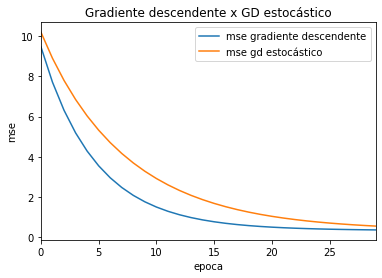

In [33]:
plot_lines(
    [metrics_d, metrics_e], 
    labels=['mse gradiente descendente', 'mse gd estocástico'],
    title='Gradiente descendente x GD estocástico',
    xlabel='epoca',
    ylabel='mse'
)

É possível observar que, para este problema, mesmo que por uma pequena diferença, o método de gradiente descendente converge um pouco mais rápido que o método de gradiente descendente estocástico.

#### Regressão Linear Regularizada Multivariada Gradiente Descendente

In [36]:
train_mse = []
test_mse = []

for penalty in range(1, 5 + 1):
    lr_h = MultivariadaGDEstocasticoRegularizada(penalty=penalty)
    lr_h.fit(X_train, y_train, learning_rate=0.1, epochs=50, batch_size=8, return_errors=True)
    train_mse.append(mse(y_train, lr_h.predict(X_train)))
    test_mse.append(mse(y_test, lr_h.predict(X_test)))

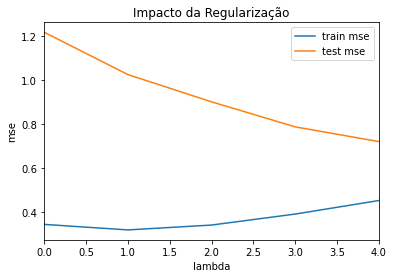

In [37]:
plot_lines(
    [train_mse, test_mse], 
    labels=['train mse', 'test mse'],
    title='Impacto da Regularização',
    xlabel='lambda',
    ylabel='mse'
)

Aplicar regularização, neste conjunto de dados, os valores de mse de treino aumentam ao aumentar o valor de $ \lambda $, mas os de teste diminuem. Isso significa que aumentar o valor de $ \lambda $ diminui o overfiting no conjunto de treino.

Para os valores testados, o melhor a ser escolhido seria 5, pois esse valor apresenta uma queda signicativa em relação ao mse de teste inicial, e o aumento em relação ao mse de treino inicial é pequeno.

#### Valores para R2 e MSE, Coeficientes e Bias

In [40]:
lrs = {
    'Regressão Linear Analitica': lr_c,
    'Regressão Linear Gradiente Descendente': lr_c,
    'Regressão Linear Gradiente Descendente Estocástico': lr_d,
    'Regressão Linear Regularizada Gradiente Descendente Estocástico': lr_h,
}

In [41]:
print_metrics(lrs)

Regressão Linear Analitica
Coeficientes: [ 1.2957738  -0.10489621  0.00623971 -0.12624331 -0.13463663]
Bias: 3.2903608438489824
Métricas treino:
	r2: 0.7843506307000438
	mse: 0.2810493788232248
Métricas teste:
	r2: 0.41799744751382006
	mse: 0.9766980914087379
Regressão Linear Gradiente Descendente
Coeficientes: [ 1.2957738  -0.10489621  0.00623971 -0.12624331 -0.13463663]
Bias: 3.2903608438489824
Métricas treino:
	r2: 0.7843506307000438
	mse: 0.2810493788232248
Métricas teste:
	r2: 0.41799744751382006
	mse: 0.9766980914087379
Regressão Linear Gradiente Descendente Estocástico
Coeficientes: [ 0.46700726  0.04427492  0.43754793 -0.11668427  0.14530821]
Bias: 3.1324209901224807
Métricas treino:
	r2: 0.7161187298449785
	mse: 0.36997397625420775
Métricas teste:
	r2: 0.24390622804620798
	mse: 1.268852414544759
Regressão Linear Regularizada Gradiente Descendente Estocástico
Coeficientes: [ 0.52339108  0.0179441   0.44458947 -0.13819934  0.12426743]
Bias: 3.614694231978583
Métricas treino:
	r2